In [1]:
import spikeextractors as se
import roiextractors as re
import pynwb 
import numpy as np
from pathlib import Path
from datetime import datetime
import belextractors as be
from nwb_conversion_tools.utils.spike_interface import write_recording, write_sorting, get_nwb_metadata
import sys
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
sys.path.append("..")
from imaging_tools import *

## Define file paths and load sync data

In [4]:
# file paths
mea_file = '...' # hdf5 file
geci_file = '...' # tiff file
sc_folder = '...' # spike sorted data 

In [9]:
recording_sync, imag_sync, sorting_sync, ttls = sync_MEA_imaging(mea_file, geci_file, sc_folder)

MEA duration: 122.73215
Ca2+ corrected sampling rate: 9.77738921708778


## Instantiate NWBFile object

In [10]:
session_start_time = get_recording_start_time(mea_file)
session_start_time

datetime.datetime(2020, 8, 14, 15, 36, 29)

In [11]:
identifier = "..."
session_description = "Simultaneous Ca2+ imaging-HD MEA recording to map monosynaptic connections."
experiment_description = ("Recording of network-wide extracellular activity with HD-MEA and "
                          "simultaneous super-resolution calcium imaging to extract single spine responses")

In [13]:
# instantiate file
nwbfile = pynwb.NWBFile(identifier=identifier, session_description=session_description, 
                        session_start_time=session_start_time)

In [14]:
# add basic metadata
nwbfile.experimenter = "Xiaohan Xue"
nwbfile.lab = "Bio Engineering Laboratory (BEL) - Department of Bio Systems Science and Engineeering (D-BSSE)"
nwbfile.institution = "ETH Zurich"
nwbfile.experiment_description = experiment_description

### Modify recording and imaging-specific metadata

In [15]:
metadata_rec = get_nwb_metadata(recording_sync)
metadata_imag = re.NwbImagingExtractor.get_nwb_metadata(imag_sync)

In [16]:
metadata_rec["Ecephys"]["Device"][0]["name"] = "Mea1k HD-MEA"
metadata_rec["Ecephys"]["Device"][0]["description"] = "Mea1k HD-MEA device with 26'400 electrodes. 1024 recorded simultaneously."
metadata_rec["Ecephys"]["ElectrodeGroup"][0]["device"] = "Mea1k HD-MEA"

In [17]:
metadata_imag["Ophys"]["Device"][0]["name"] = "Nikon NiE upright confocal microscope"
metadata_imag["Ophys"]["Device"][0]["description"] = "Nikon NiE upright microscope equipped with Yokogawa W1 spinning disk scan head, an Andor iXon Ultra EMCCD camera (Oxford Instruments), and 40x/0.80 NA or 60x/1.00 NA water-objectives (Nikon)"
metadata_imag["Ophys"]["ImagingPlane"][0]["description"] = "Post-synaptic cell plane"
metadata_imag["Ophys"]["ImagingPlane"][0]["indicator"] = "jGCaMP7b"
metadata_imag["Ophys"]["ImagingPlane"][0]["excitation_lambda"] = "488"
metadata_imag["Ophys"]["ImagingPlane"][0]["optical_channel"][0]["emission_lambda"] = "525"

## Add recording (only metadata), sorting, and imaging data

In [18]:
# export Device and electrode info (no raw traces)
write_recording(recording_sync, metadata=metadata_rec, nwbfile=nwbfile, 
                write_electrical_series=True)

root pynwb.file.NWBFile at 0x140317413513056
Fields:
  acquisition: {
    ElectricalSeries_raw <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    Mea1k HD-MEA <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    0 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Recording of network-wide extracellular activity with HD-MEA and simultaneous super-resolution calcium imaging to extract single spine responses
  experimenter: Xiaohan Xue
  file_create_date: [datetime.datetime(2022, 2, 10, 22, 42, 53, 485736, tzinfo=tzlocal())]
  identifier: rec3_chip2765
  institution: ETH Zurich
  lab: Bio Engineering Laboratory (BEL) - Department of Bio Systems Science and Engineeering (D-BSSE)
  session_description: Simultaneous Ca2+ imaging-HD MEA recording to map monosynaptic connections.
  session_start_time: 2020-08-14 15:36:29+02:00
  timestamps_reference_time: 2020-08-14 15:36:29+02:00

In [19]:
nwbfile

root pynwb.file.NWBFile at 0x140317413513056
Fields:
  acquisition: {
    ElectricalSeries_raw <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    Mea1k HD-MEA <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    0 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Recording of network-wide extracellular activity with HD-MEA and simultaneous super-resolution calcium imaging to extract single spine responses
  experimenter: Xiaohan Xue
  file_create_date: [datetime.datetime(2022, 2, 10, 22, 42, 53, 485736, tzinfo=tzlocal())]
  identifier: rec3_chip2765
  institution: ETH Zurich
  lab: Bio Engineering Laboratory (BEL) - Department of Bio Systems Science and Engineeering (D-BSSE)
  session_description: Simultaneous Ca2+ imaging-HD MEA recording to map monosynaptic connections.
  session_start_time: 2020-08-14 15:36:29+02:00
  timestamps_reference_time: 2020-08-14 15:36:29+02:00

In [20]:
# export sorted data
se.NwbSortingExtractor.write_sorting(sorting=sorting_sync, nwbfile=nwbfile)

In [21]:
nwbfile.units

units pynwb.misc.Units at 0x140317417497120
Fields:
  colnames: ['spike_times']
  columns: (
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>
  )
  description: Autogenerated by NWBFile
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  waveform_unit: volts

In [22]:
# export imaging data
re.NwbImagingExtractor.write_imaging(imaging=imag_sync, use_times=True, nwbfile=nwbfile, metadata=metadata_imag)
# del nwbfile.devices["Microscope"]

In [23]:
# check fields
nwbfile.devices['Nikon NiE upright confocal microscope'].description

'Nikon NiE upright microscope equipped with Yokogawa W1 spinning disk scan head, an Andor iXon Ultra EMCCD camera (Oxford Instruments), and 40x/0.80 NA or 60x/1.00 NA water-objectives (Nikon)'

## (optional) write spine ROI and traces

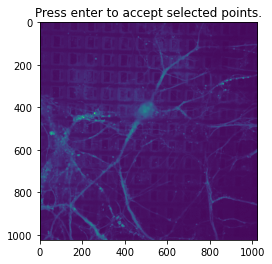

In [24]:
avg_im = compute_avg_video(imag_sync, stride=100)
rois= select_rois(avg_im) # select spines and respective shafts, in sequence 

In [25]:
sav_data = np.load('../rec3_200814/saved_data_P1.npz')
sav_data['best_r'], sav_data.files

(array(0.2939227),
 ['ds_idxs',
  'best_match',
  'best_r',
  'second_match',
  'individual_frs_ds_dff',
  'keep',
  'traces_dff_spine',
  'traces_dff_shaft',
  'rois_spine',
  'rois_shaft'])

In [26]:
trace_spine = extract_roi_activity(imag_sync, sav_data['rois_spine'])
trace_dff_spine, _ = dff(trace_spine)
trace_shaft = extract_roi_activity(imag_sync, sav_data['rois_shaft'])
trace_dff_shaft, _ = dff(trace_shaft)

Extracting ROI of size 21: 100%|###########################################################################################| 1200/1200 [00:00<00:00, 2323.08it/s]


In [27]:
# create masks
mask_spine = np.zeros(shape=imag_sync.get_image_size(), dtype=bool)
for x, y in sav_data['rois_spine']:
    mask_spine[y, x] = 1
mask_shaft = np.zeros(shape=imag_sync.get_image_size(), dtype=bool)
for x, y in sav_data['rois_shaft']:
    mask_shaft[y, x] = 1

In [28]:
masks = np.stack([mask_spine, mask_shaft], 2)
raw_traces = np.vstack([trace_spine, trace_shaft])
dff_traces = np.vstack([trace_dff_spine, trace_dff_shaft])

In [29]:
seg = re.NumpySegmentationExtractor(image_masks=masks, raw=raw_traces, dff=dff_traces, 
                                    channel_names=["Channel 0"],
                                    sampling_frequency=imag_sync.get_sampling_frequency(),
                                    )

In [30]:
seg.get_roi_ids()

[0, 1]

In [31]:
metadata_seg = re.NwbSegmentationExtractor.get_nwb_metadata(seg)
metadata_seg

{'NWBFile': {'session_start_time': datetime.datetime(2022, 2, 10, 22, 43, 54, 492105),
  'identifier': 'ac4c550e-e6e6-4449-b2c7-f0eeb22f6959',
  'session_description': 'no description'},
 'Ophys': {'Device': [{'name': 'Microscope'}],
  'Fluorescence': {'roi_response_series': [{'name': 'RoiResponseSeries',
     'description': 'array of raw fluorescence traces',
     'rate': 9.77738921708778},
    {'name': 'Dff',
     'description': 'description of dff traces',
     'rate': 9.77738921708778}]},
  'ImageSegmentation': {'plane_segmentations': [{'description': 'Segmented ROIs',
     'name': 'PlaneSegmentation'}]},
  'ImagingPlane': [{'name': 'ImagingPlane',
    'description': 'no description',
    'excitation_lambda': nan,
    'indicator': 'unknown',
    'location': 'unknown',
    'optical_channel': [{'name': 'Channel 0',
      'emission_lambda': nan,
      'description': 'no description'}],
    'imaging_rate': 9.77738921708778}]}}

In [32]:
metadata_seg["Ophys"]["Device"][0] = metadata_imag["Ophys"]["Device"][0]
metadata_seg["Ophys"]["ImagingPlane"][0] = metadata_imag["Ophys"]["ImagingPlane"][0]
metadata_seg["Ophys"]["ImageSegmentation"]["plane_segmentations"][0]["description"] = "Spine and adjacent shaft ROIs. Even ROI are spines, Odds are correspondent shafts."
metadata_seg["Ophys"]["Fluorescence"]["roi_response_series"][0]["description"] = "Raw traces"
metadata_seg["Ophys"]["Fluorescence"]["roi_response_series"][1]["description"] = "Dff and detrended traces"

In [33]:
metadata_seg

{'NWBFile': {'session_start_time': datetime.datetime(2022, 2, 10, 22, 43, 54, 492105),
  'identifier': 'ac4c550e-e6e6-4449-b2c7-f0eeb22f6959',
  'session_description': 'no description'},
 'Ophys': {'Device': [{'name': 'Nikon NiE upright confocal microscope',
    'description': 'Nikon NiE upright microscope equipped with Yokogawa W1 spinning disk scan head, an Andor iXon Ultra EMCCD camera (Oxford Instruments), and 40x/0.80 NA or 60x/1.00 NA water-objectives (Nikon)'}],
  'Fluorescence': {'roi_response_series': [{'name': 'RoiResponseSeries',
     'description': 'Raw traces',
     'rate': 9.77738921708778},
    {'name': 'Dff',
     'description': 'Dff and detrended traces',
     'rate': 9.77738921708778}]},
  'ImageSegmentation': {'plane_segmentations': [{'description': 'Spine and adjacent shaft ROIs. Even ROI are spines, Odds are correspondent shafts.',
     'name': 'PlaneSegmentation'}]},
  'ImagingPlane': [{'name': 'ImagingPlane',
    'description': 'Post-synaptic cell plane',
    'ex

In [34]:
re.NwbSegmentationExtractor.write_segmentation(seg, nwbfile=nwbfile, metadata=metadata_seg)
del nwbfile.devices["Microscope"]

writing nwb for NumpySegmentationExtractor



In [35]:
nwbfile

root pynwb.file.NWBFile at 0x140317413513056
Fields:
  acquisition: {
    ElectricalSeries_raw <class 'pynwb.ecephys.ElectricalSeries'>,
    TwoPhotonSeries <class 'pynwb.ophys.TwoPhotonSeries'>
  }
  devices: {
    Mea1k HD-MEA <class 'pynwb.device.Device'>,
    Nikon NiE upright confocal microscope <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    0 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Recording of network-wide extracellular activity with HD-MEA and simultaneous super-resolution calcium imaging to extract single spine responses
  experimenter: Xiaohan Xue
  file_create_date: [datetime.datetime(2022, 2, 10, 22, 42, 53, 485736, tzinfo=tzlocal())]
  identifier: rec3_chip2765
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: ETH Zurich
  lab: Bio Engineering Laboratory (BEL) - Department of Bio Systems Science and Engineeering (D-BSSE)
  pro

## Write file

In [36]:
nwb_file_name = f"{identifier}.nwb"
nwb_file_name

'rec3_chip2765.nwb'

In [37]:
with pynwb.NWBHDF5IO(nwb_file_name, "w") as io:
    io.write(nwbfile)